# Meal Allowance Optimization: Price, Inflation and Prediction

## **Introduction**

[Employee meal allowances are essential elements of compensation packages](https://www.hubengage.com/employee-experience/significance-and-impact-of-employee-allowances/), directly influencing employee satisfaction and well-being. However, [fluctuating food prices and inflation can challenge the maintenance of their real value](https://www.shrm.org/topics-tools/flagships/all-things-work/the-wage-inflation-challenge----balancing-business-sustainabilit). This project [addresses the need for a data-driven approach to optimize MotorPH's employee meal allowance, ensuring its continued adequacy and relevance](https://business.doordash.com/en-us/resources/research-shows-meal-benefits-improve-employee-satisfaction). By leveraging [historical food price data and economic indicators, the study provides actionable insights and recommendations](https://psa.gov.ph/price-indices/cpi-ir?utm_source=chatgpt.com). The project employs R and Jupyter Lab as powerful tools for data analysis, visualization, and statistical modeling, demonstrating their practical utility in solving real-world business challenges.

## **Objectives**

The primary objectives of this project are as follows:

- To develop a base meal price model using historical food price data from MotorPH's data repository.
- To implement an inflation-adjusted meal allowance model using the Consumer Price Index (CPI) and a proxy Cost of Living Adjustment (COLA).
- To create a predictive model to forecast future meal costs, enabling proactive budgeting.
- To provide data-driven recommendations for optimizing MotorPH's employee meal allowance.

**Data Cleaning and Preparation**
- Main Dataset: [Food Prices](https://github.com/imperionite/insighted/blob/main/DataCleaning_FoodPrices.ipynb)
- Supplementary Dataset: [Employees Record](https://github.com/imperionite/insighted/blob/main/DataCleaning_Employees.ipynb)

In [3]:
# Load Libraries
library(ggplot2)
library(dplyr)
library(lubridate) 
library(RColorBrewer)
library(viridis)
library(tidyr)  
library(treemap)
library(gridExtra)

In [4]:
options(repr.plot.width = 14, repr.plot.height = 11)

# Load CSV
food_prices <- read.csv("food_prices_ph_cleaned.csv", stringsAsFactors = TRUE)
employees <- read.csv("employees_details_cleaned.csv", stringsAsFactors = TRUE)

# Convert Date to date format
food_prices$Date <- as.Date(food_prices$Date)

# Ensure that numeric columns are properly formatted
food_prices$Price <- as.numeric(food_prices$Price)

# Extract year
food_prices$Year <- year(food_prices$Date)


# Filter for dates from 2019 onwards and exclude Unit entries
food_prices <- food_prices %>%
  filter(year(Date) >= 2019, Unit != "Unit")


# Exclude Unit entries
food_prices <- food_prices %>%
  filter(Unit != "Unit")


### Option 1: Meal Price Model Development

#### Category Assignment & Unit Price Calculation

In [5]:
# Ingredient categories
ingredient_categories <- list(
  protein = c("Meat (pork)", "Meat (beef, chops with bones)", "Meat (chicken, whole)", "Fish (fresh)", "Fish (frigate tuna)", "Fish (mackerel, fresh)", "Fish (tilapia)", "Fish (roundscad)", "Fish (slipmouth)", "Fish (threadfin bream)", "Beans (mung)", "Groundnuts (unshelled)", "Groundnuts (shelled)", "Eggs", "Eggs (duck)", "Meat (pork, with bones)", "Meat (beef)", "Meat (pork, hock)", "Meat (pork, with fat)", "Shrimp (endeavor)", "Shrimp (tiger)", "Crab", "Fish (redbelly yellowtail fusilier)", "Fish (milkfish)"),
  carbohydrate = c("Rice (milled, superior)", "Rice (regular, milled)", "Rice (premium)", "Rice (special)", "Rice (well milled)", "Maize flour (yellow)", "Maize flour (white)", "Maize (yellow)", "Maize (white)", "Potatoes (Irish)", "Sweet potatoes", "Semolina (white)", "Semolina (yellow)", "Taro"),
  vegetables = c("Cabbage", "Cabbage (chinese)", "Carrots", "Garlic", "Onions (red)", "Onions (white)", "Tomatoes", "Eggplants", "Bitter melon", "Bottle gourd", "Choko", "Water spinach", "Sweet Potato leaves", "Choko", "Water spinach"),
  fruits = c("Bananas (latundan)", "Bananas (saba)", "Bananas (lakatan)", "Mangoes (carabao)", "Mangoes (piko)", "Pineapples", "Coconut"),
  oils_and_condiments = c("Oil (cooking)", "Sugar (brown)", "Sugar (white)", "Garlic (large)", "Garlic (small)", "Ginger", "Calamansi", "Anchovies")
)

# Category assignment
food_prices$Category <- sapply(food_prices$Commodity, function(x) {
  if (x %in% ingredient_categories$protein) return("Protein")
  if (x %in% ingredient_categories$carbohydrate) return("Carbohydrate")
  if (x %in% ingredient_categories$vegetables) return("Vegetable")
  if (x %in% ingredient_categories$fruits) return("Fruit")
  if (x %in% ingredient_categories$oils_and_condiments) return("Oils and Condiments")
  return("Other")
})

# Unit price calculation (per kg)
food_prices <- food_prices %>%
  mutate(UnitPrice_kg = ifelse(Unit == "750 ML" & Commodity == "Oil (cooking)", Price / (0.75 * 0.92),
                               ifelse(Unit == "KG", Price, NA))) %>%
  filter(!is.na(UnitPrice_kg)) # Remove rows where UnitPrice_kg is NA

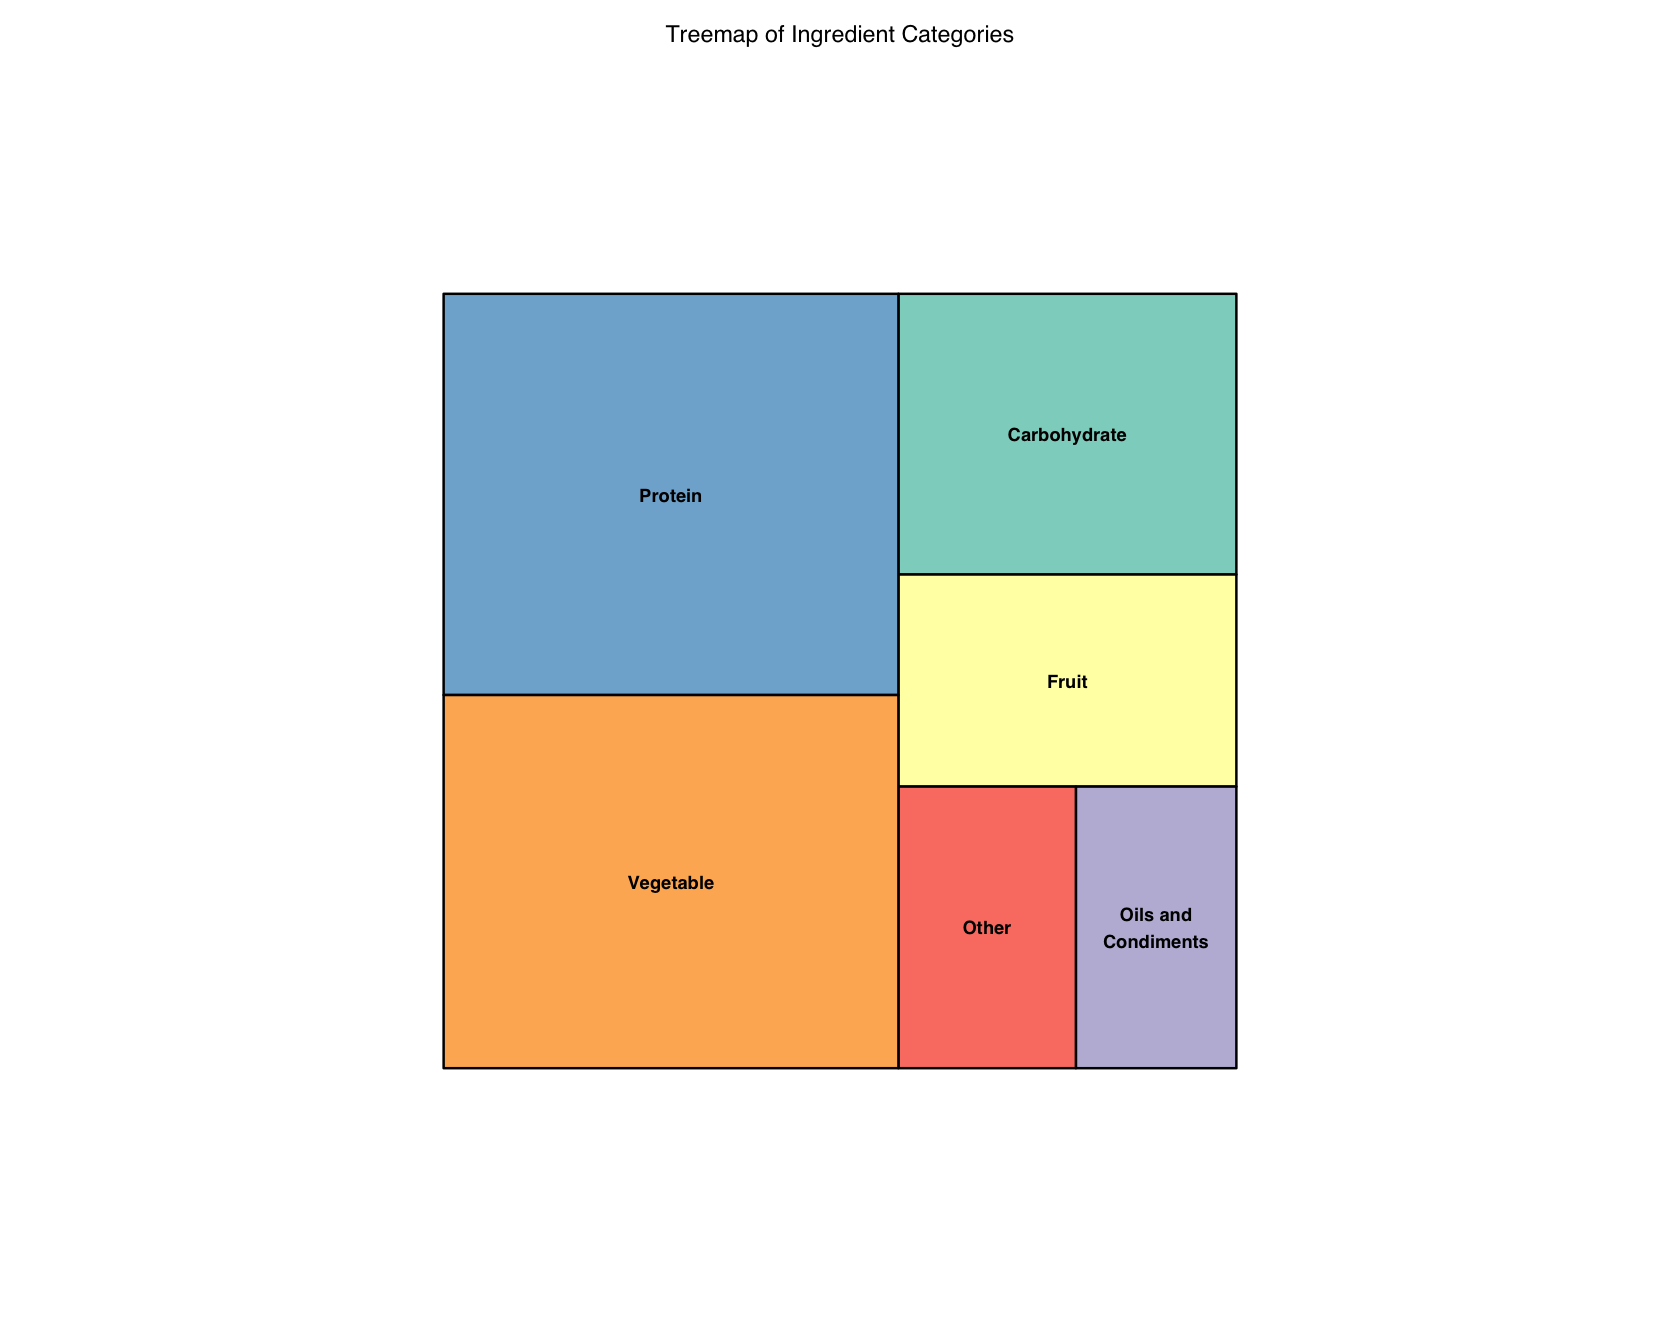

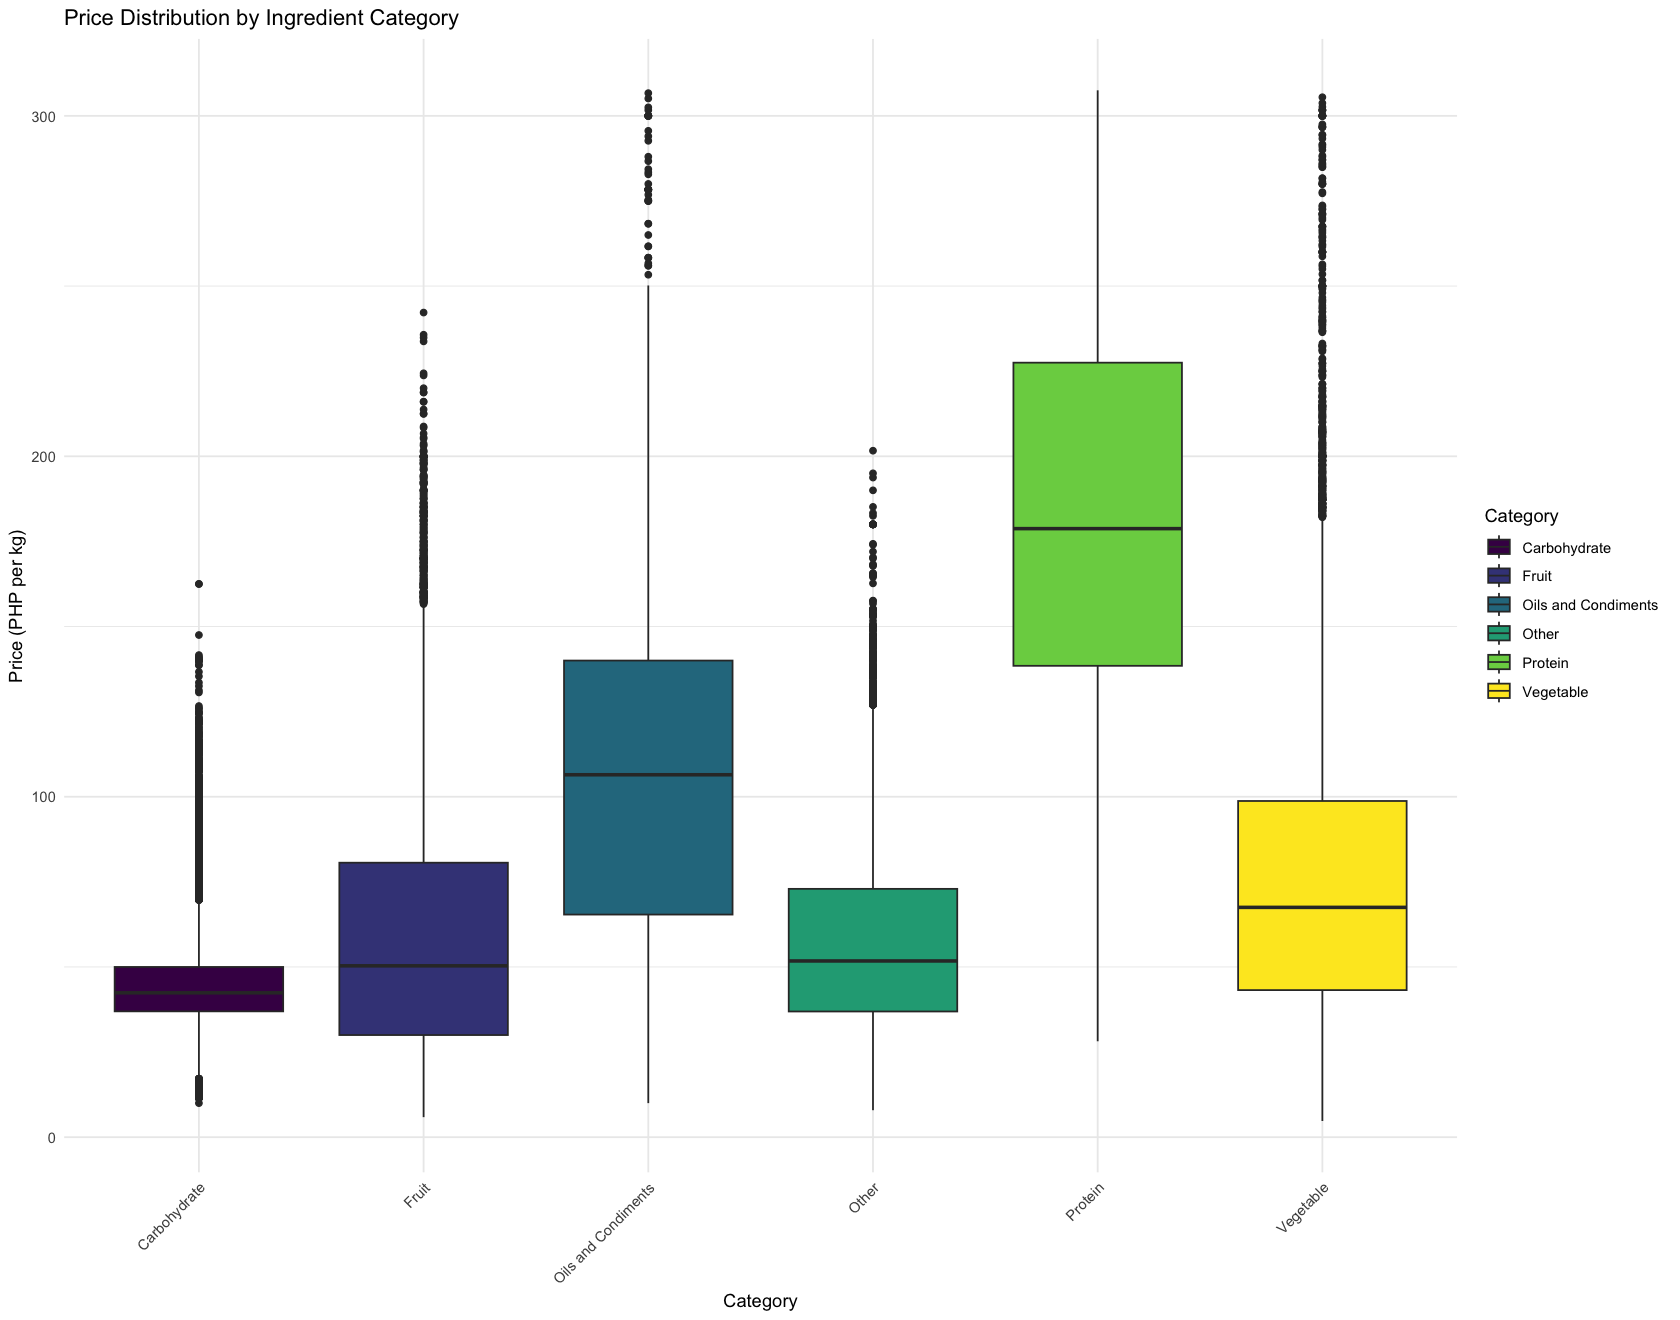

In [6]:
# Treemap: Visual breakdown of ingredient categories
category_size <- food_prices %>%
  count(Category)

treemap(category_size,
        index = "Category",
        vSize = "n",
        title = "Treemap of Ingredient Categories",
        palette = "Set3")

## Boxplot: Price distribution by category
ggplot(food_prices, aes(x = Category, y = UnitPrice_kg, fill = Category)) +
  geom_boxplot() +
  scale_fill_viridis_d() +
  theme_minimal() +
  labs(title = "Price Distribution by Ingredient Category",
       x = "Category", y = "Price (PHP per kg)",
       fill = "Category") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


**TreeMap: Visual Breakdown of Ingredient Categories**  

The treemap provides a clear and intuitive visual representation of the relative size of each ingredient category based on the number of commodities included. Each rectangle represents a category, and the size of the rectangle reflects the number of items assigned to that category. From this visualization, we can observe that the **Protein** category occupies the largest space, indicating that it has the highest variety of items, such as different types of meat, fish, and eggs. This suggests a broad diversity of protein sources in the dataset.  

**Vegetables** also make up a significant portion, demonstrating the wide range of plant-based food items. **Carbohydrates**, **Fruits**, and **Oils and Condiments** are relatively smaller categories, indicating fewer distinct commodities in these groups. The distinct coloring from the "Set3" palette makes it easy to differentiate between the categories, offering an at-a-glance understanding of the composition of food types in the dataset.  

**Boxplot: Price Distribution by Category**  

The boxplot provides a statistical summary of the price distribution for each ingredient category in terms of unit price (PHP per kg). It reveals the spread, central tendency, and potential outliers within each category.  

- **Protein** shows the widest spread in price, with a high interquartile range and several outliers at the higher end, likely reflecting the variety in types of meat and seafood, which have varying market prices.  
- **Carbohydrates** have relatively lower and more consistent prices, with a smaller spread and fewer extreme values, which aligns with staple food items like rice and maize typically having stable pricing.  
- **Vegetables** show moderate price variability, likely reflecting differences in availability and perishability across different vegetable types.  
- **Fruits** display a tighter price range but with some high-end outliers, suggesting occasional spikes for premium fruits like mangoes or seasonal factors affecting pricing.  
- **Oils and Condiments** have the smallest spread and generally lower prices, consistent with essential but lower-cost cooking ingredients.  

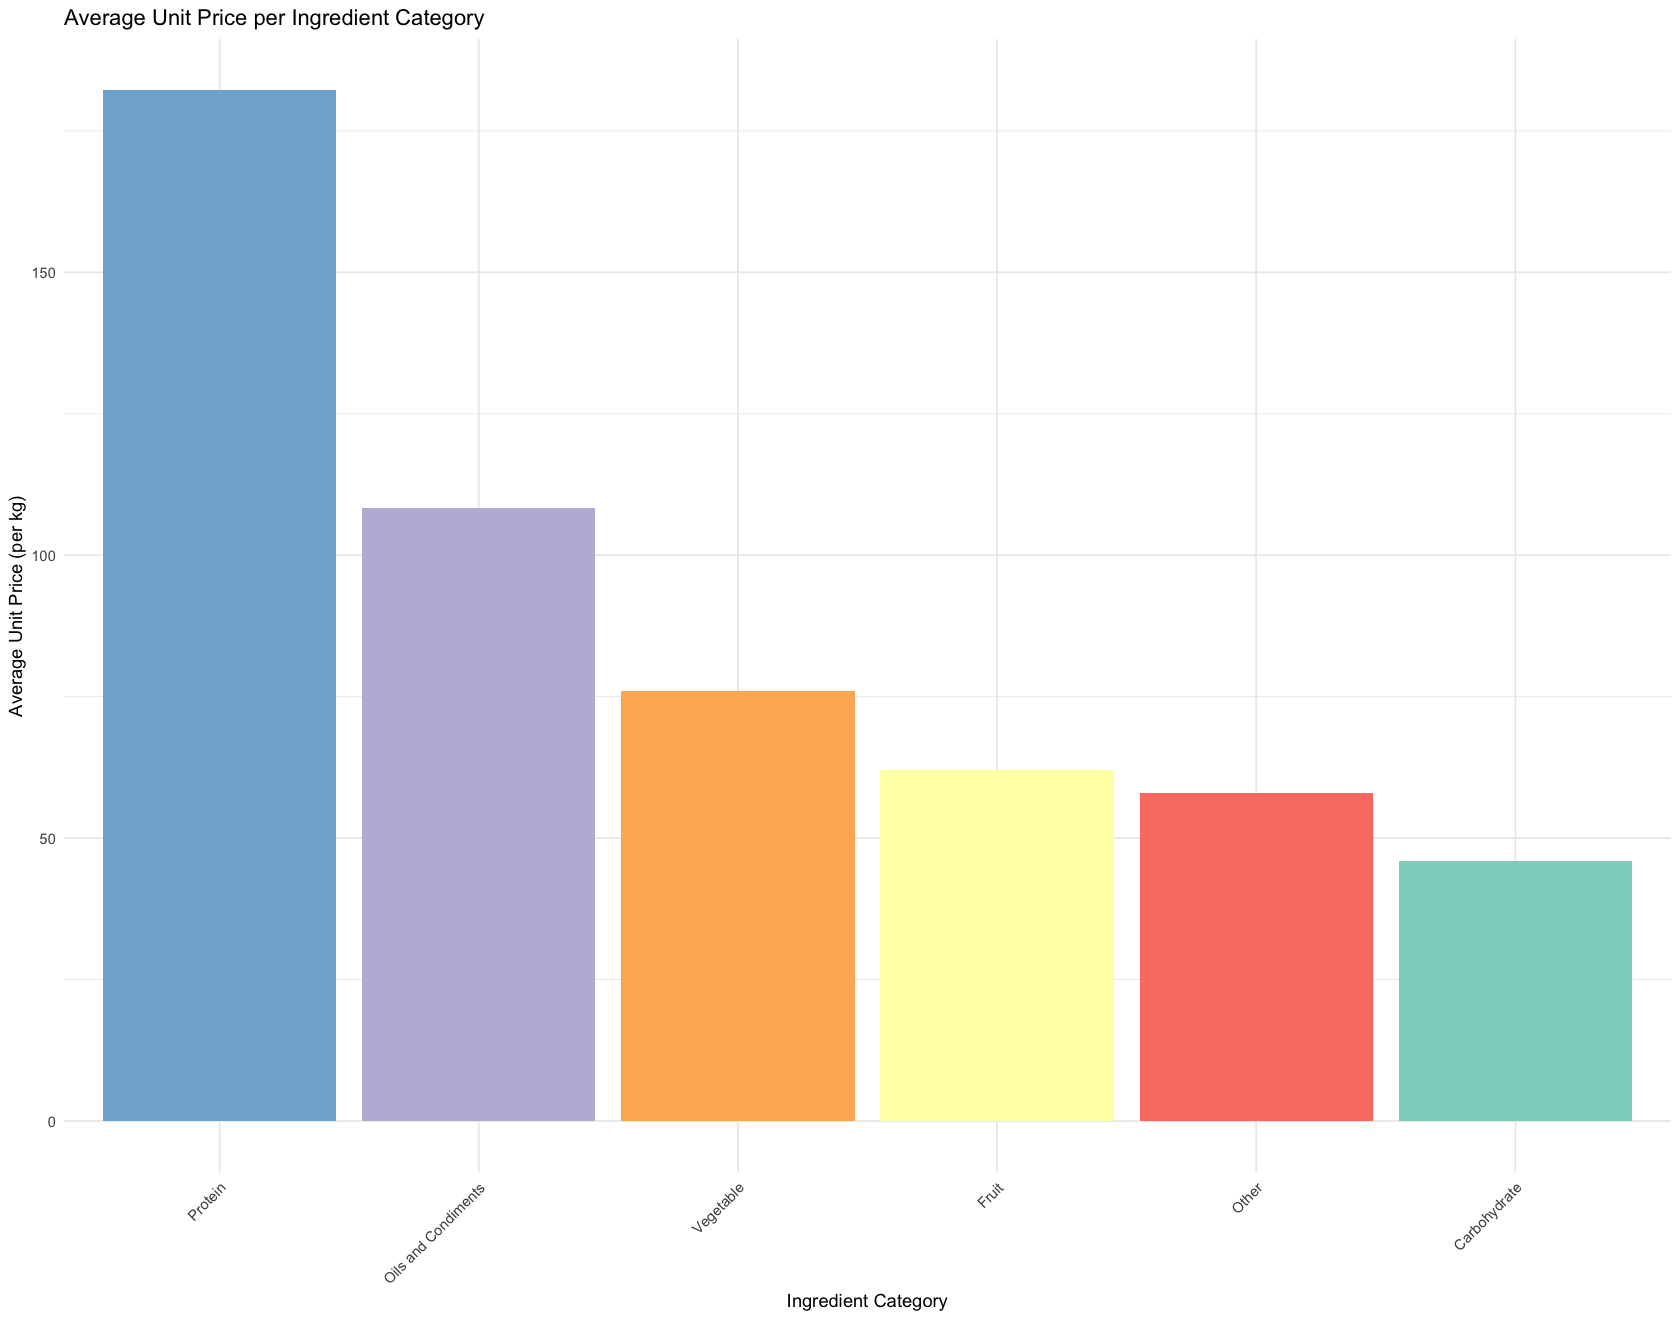

In [7]:
# Average unit price per category
#  Category Distribution Visualization
avg_price <- food_prices %>%
  group_by(Category) %>%
  summarise(Avg_UnitPrice = mean(UnitPrice_kg, na.rm = TRUE)) %>%
  arrange(desc(Avg_UnitPrice))

# Bar plot
ggplot(avg_price, aes(x = reorder(Category, -Avg_UnitPrice), y = Avg_UnitPrice, fill = Category)) +
  geom_bar(stat = "identity", show.legend = FALSE) +
  theme_minimal() +
  scale_fill_brewer(palette = "Set3") +
  labs(title = "Average Unit Price per Ingredient Category",
       x = "Ingredient Category",
       y = "Average Unit Price (per kg)") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


**Bar Chart: Average Unit Price by Category**

The bar chart presents the average unit price per kilogram for each ingredient category. This visualization clearly shows the cost disparities among food types. Protein-based ingredients exhibit the highest average prices, which is expected given the market value of fresh meat and seafood. Oils and condiments also show relatively high costs due to the inclusion of cooking oil and specialty seasonings. Carbohydrates, on the other hand, demonstrate the lowest average price, largely due to the affordability and accessibility of rice products. The moderate pricing of vegetables and fruits reflects their varying seasonal availability and market demand. This chart is crucial for understanding cost drivers when proposing meal allowances, ensuring that budget allocations reflect realistic food pricing trends.

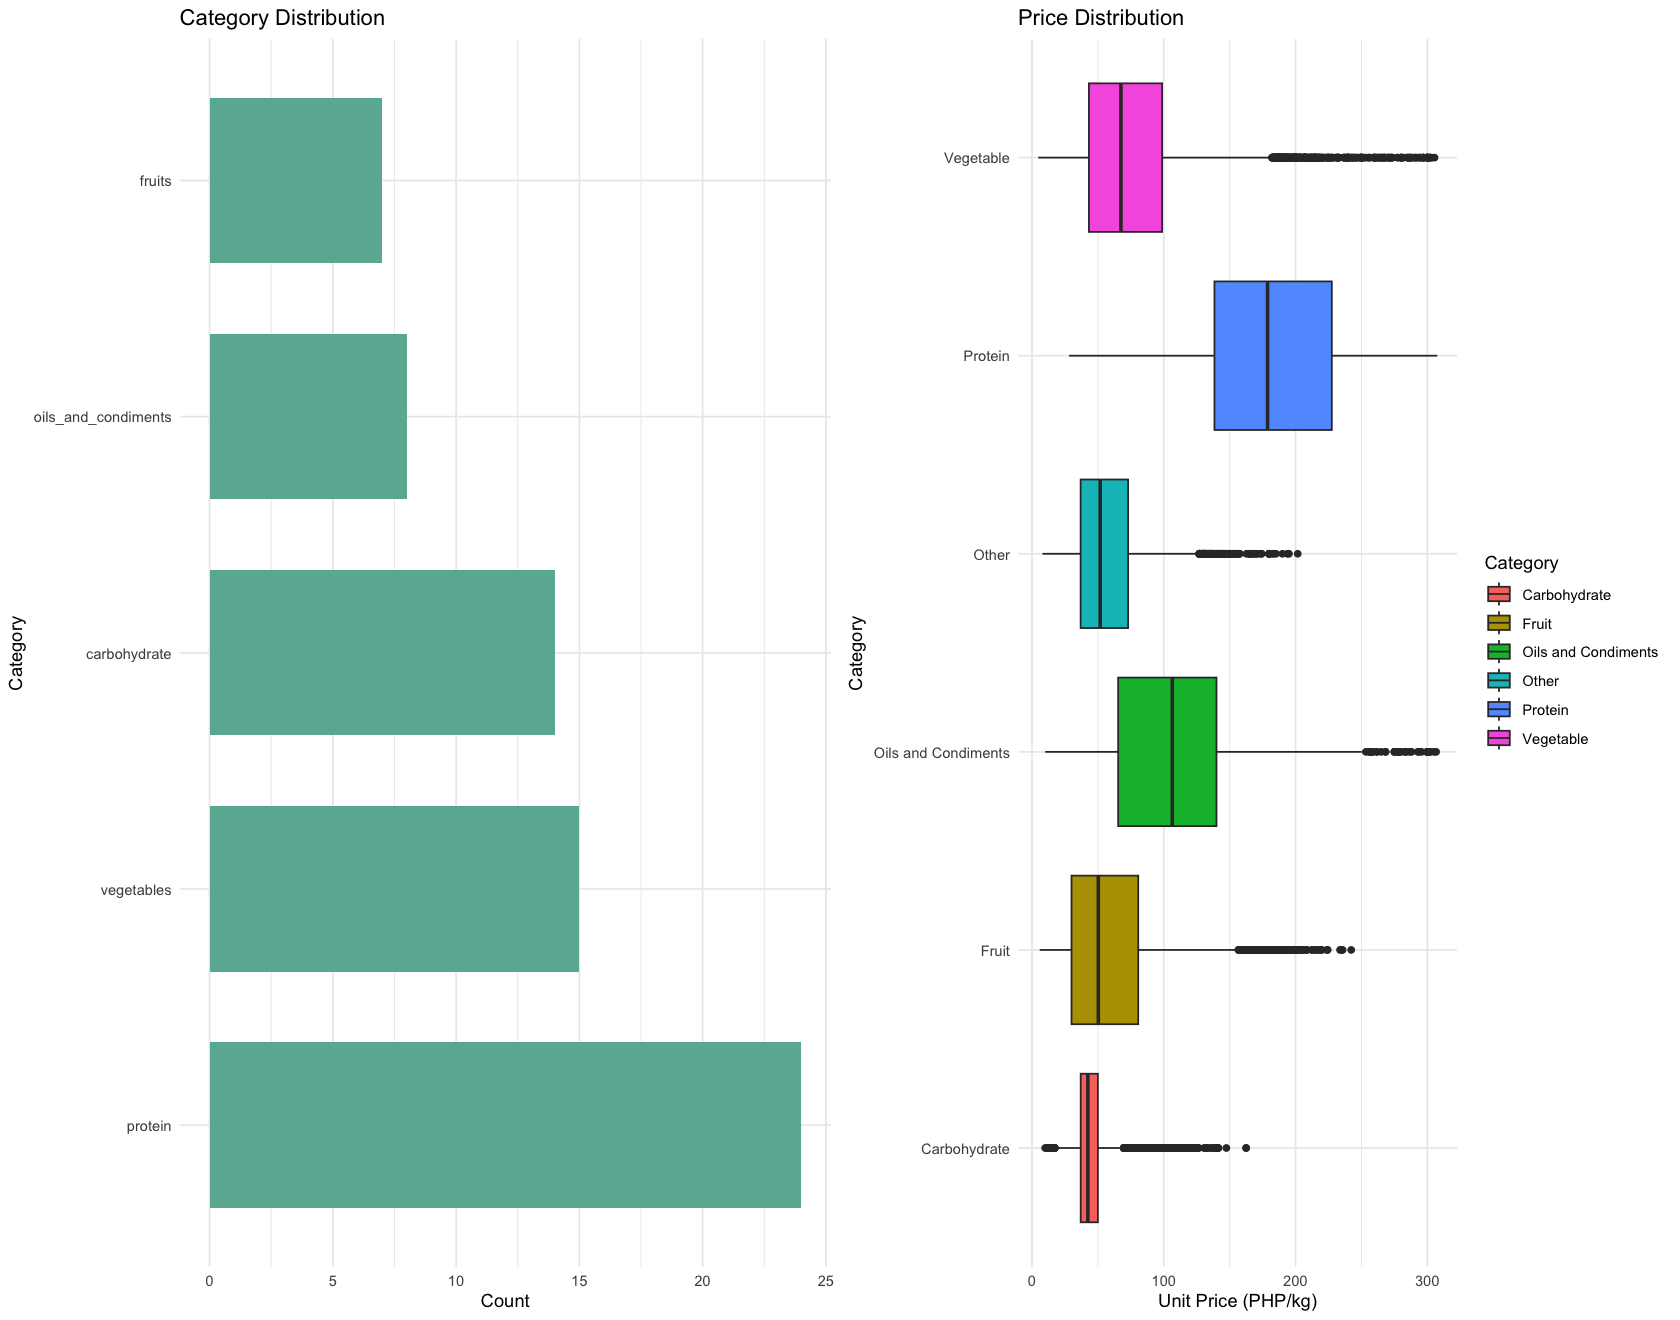

In [8]:
category_counts <- data.frame(
  Category = names(ingredient_categories),
  Count = sapply(ingredient_categories, length)
)

# Create individual plots
p1 <- ggplot(category_counts, aes(x = reorder(Category, -Count), y = Count)) +
  geom_col(width = 0.7, fill = "#69b3a2") +
  coord_flip() +
  theme_minimal() +
  labs(title = "Category Distribution", x = "Category", y = "Count")

p2 <- ggplot(food_prices, aes(x = Category, y = UnitPrice_kg, fill = Category)) +
  geom_boxplot() +
  coord_flip() +
  theme_minimal() +
  labs(title = "Price Distribution", x = "Category", y = "Unit Price (PHP/kg)")

# Combine plots
grid.arrange(p1, p2, ncol = 2)


The multi-panel visualization created here provides a comprehensive side-by-side view of ingredient categories and their respective price distributions:

1. **Category Distribution (Left Panel)**: This horizontal bar chart shows the frequency of each ingredient category in the dataset. The visual clearly highlights which categories are most prevalent, offering insight into the composition of the food price data. The use of horizontal bars makes it easier to compare the counts across categories and quickly identify the most and least represented groups.

2. **Price Distribution (Right Panel)**: The boxplot visualizes the spread and central tendency of unit prices for each category. It effectively captures the variation in pricing, including the median, interquartile range, and outliers. The flipped orientation aligns well with the category distribution plot, facilitating a direct comparison between the frequency of categories and their respective price behaviors.

#### Average Price Calculation

In [9]:
# Average price per category per year
yearly_avg_prices <- food_prices %>%
  group_by(Year, Category) %>%
  summarize(Avg_Price = mean(UnitPrice_kg, na.rm = TRUE), .groups="keep") %>%
  pivot_wider(names_from = Category, values_from = Avg_Price)

# Imputation (fill NA with previous year's value, if available, otherwise 0)
yearly_avg_prices <- yearly_avg_prices %>%
  arrange(Year) %>%
  mutate(
    Protein = ifelse(is.na(Protein), lag(Protein, default = 0), Protein),
    Carbohydrate = ifelse(is.na(Carbohydrate), lag(Carbohydrate, default = 0), Carbohydrate),
    Vegetable = ifelse(is.na(Vegetable), lag(Vegetable, default = 0), Vegetable),
    Fruit = ifelse(is.na(Fruit), lag(Fruit, default = 0), Fruit),
    `Oils and Condiments` = ifelse(is.na(`Oils and Condiments`), lag(`Oils and Condiments`, default = 0), `Oils and Condiments`),
    Other = ifelse(is.na(Other), lag(Other, default = 0), Other)
  )

# Replace the first NA values in each column with 0.
yearly_avg_prices <- yearly_avg_prices %>%
  mutate(
    Protein = ifelse(is.na(Protein), 0, Protein),
    Carbohydrate = ifelse(is.na(Carbohydrate), 0, Carbohydrate),
    Vegetable = ifelse(is.na(Vegetable), 0, Vegetable),
    Fruit = ifelse(is.na(Fruit), 0, Fruit),
    `Oils and Condiments` = ifelse(is.na(`Oils and Condiments`), 0, `Oils and Condiments`),
    Other = ifelse(is.na(Other), 0, Other)
  )

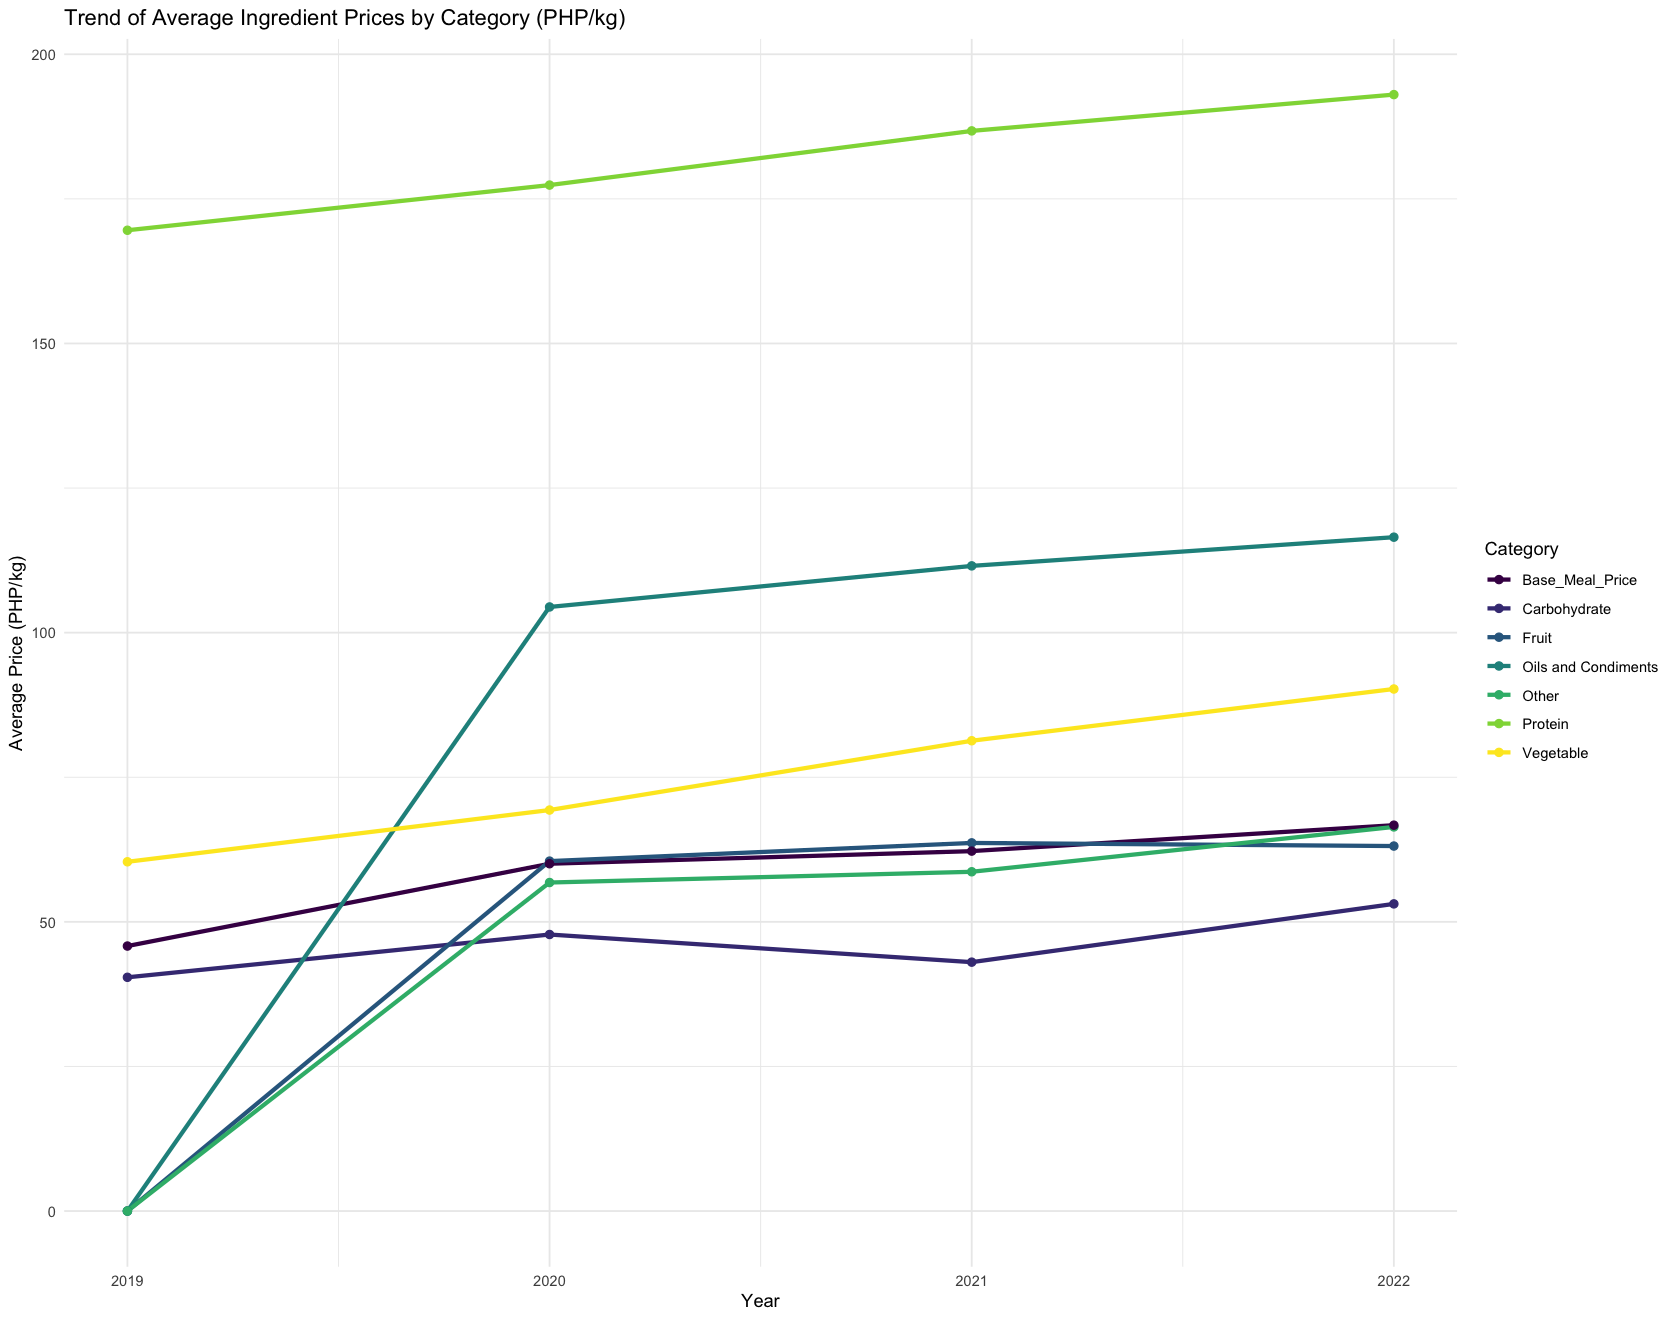

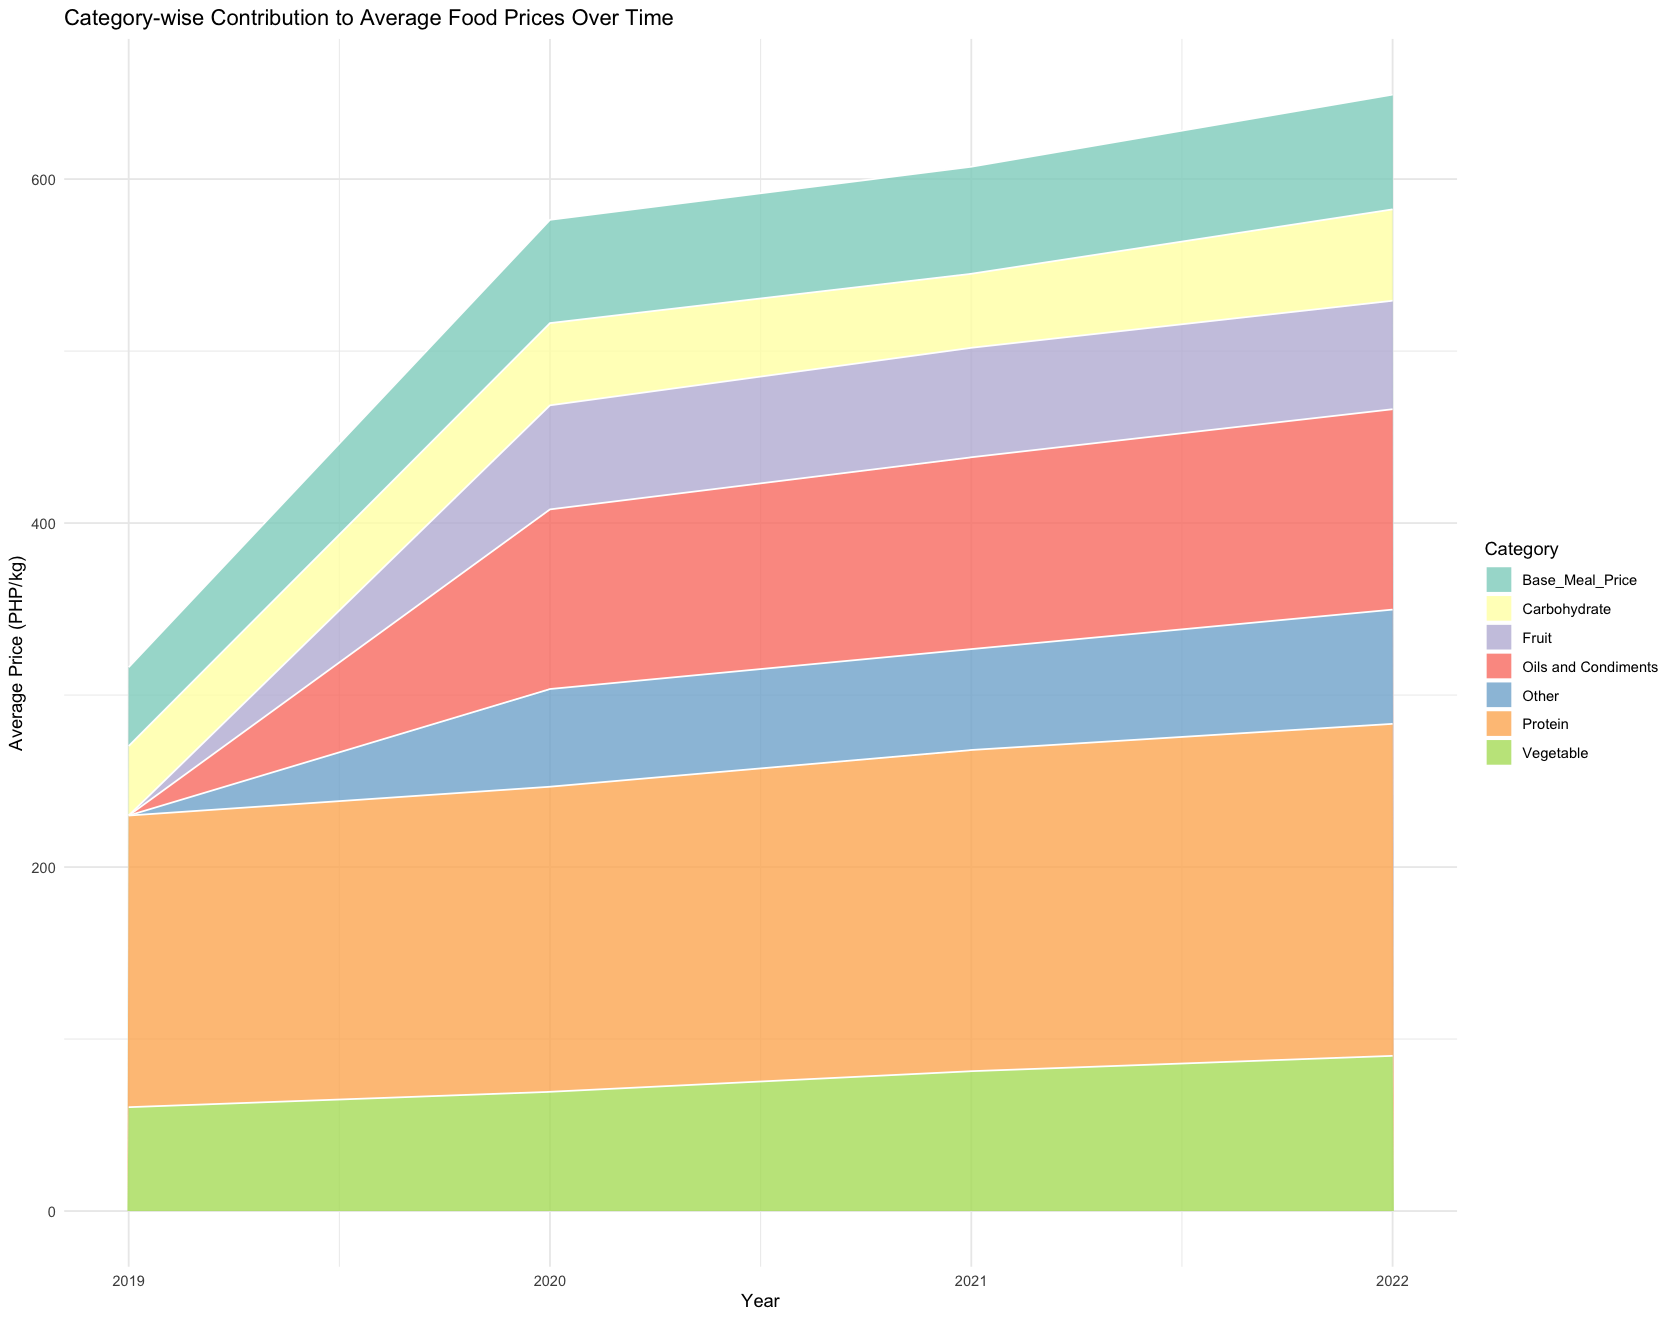

In [22]:
# Line plot of average prices over time by category
yearly_avg_prices_long <- yearly_avg_prices %>%
  pivot_longer(cols = -Year, names_to = "Category", values_to = "Avg_Price")

ggplot(yearly_avg_prices_long, aes(x = Year, y = Avg_Price, color = Category)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  scale_color_viridis_d() +
  theme_minimal() +
  labs(title = "Trend of Average Ingredient Prices by Category (PHP/kg)",
       x = "Year",
       y = "Average Price (PHP/kg)",
       color = "Category")

# Stacked area plot to show category price share over time
ggplot(yearly_avg_prices_long, aes(x = Year, y = Avg_Price, fill = Category)) +
  geom_area(alpha = 0.8, color = "white", size = 0.5) +
  scale_fill_brewer(palette = "Set3") +
  theme_minimal() +
  labs(title = "Category-wise Contribution to Average Food Prices Over Time",
       x = "Year",
       y = "Average Price (PHP/kg)",
       fill = "Category")


**Line Plot: Average Prices Over Time**
   This plot illustrates the yearly trend of average ingredient prices, categorized into Protein, Carbohydrate, Vegetable, Fruit, Oils and Condiments, and Other. The use of distinct colors from the Viridis palette ensures clarity and visual distinction. This plot helps identify patterns, such as consistent price increases, volatility, or stability in specific categories. Notably, Protein often exhibits higher average prices compared to other categories, while Fruits and Vegetables show more variability.

**Stacked Area Plot: Category Price Share**
   This plot shows the relative contribution of each category to overall average food prices over time. This plot is useful for visualizing how the proportion of each category's pricing evolves, indicating possible shifts in market demand or supply trends. 

In [11]:
### # Meal composition in grams
protein_weight <- 175 # grams
carb_weight <- 250 # grams
veg_weight <- 100 # grams
fruit_weight <- 150 # grams
oils_and_condiments_weight <- 10 # grams

# Calculate base meal price per year
yearly_avg_prices$Base_Meal_Price <-
  (protein_weight * yearly_avg_prices$Protein / 1000) +
  (carb_weight * yearly_avg_prices$Carbohydrate / 1000) +
  (veg_weight * yearly_avg_prices$Vegetable / 1000) +
  (fruit_weight * yearly_avg_prices$Fruit / 1000) +
  (oils_and_condiments_weight * yearly_avg_prices$`Oils and Condiments` / 1000)

print(yearly_avg_prices)

# A tibble: 4 × 8
# Groups:   Year [4]
   Year Carbohydrate Protein Vegetable Fruit `Oils and Condiments` Other
  <dbl>        <dbl>   <dbl>     <dbl> <dbl>                 <dbl> <dbl>
1  2019         40.4    170.      60.4   0                      0    0  
2  2020         47.8    177.      69.3  60.5                  104.  56.8
3  2021         43.0    187.      81.3  63.7                  112.  58.7
4  2022         53.1    193.      90.3  63.1                  117.  66.4
# ℹ 1 more variable: Base_Meal_Price <dbl>


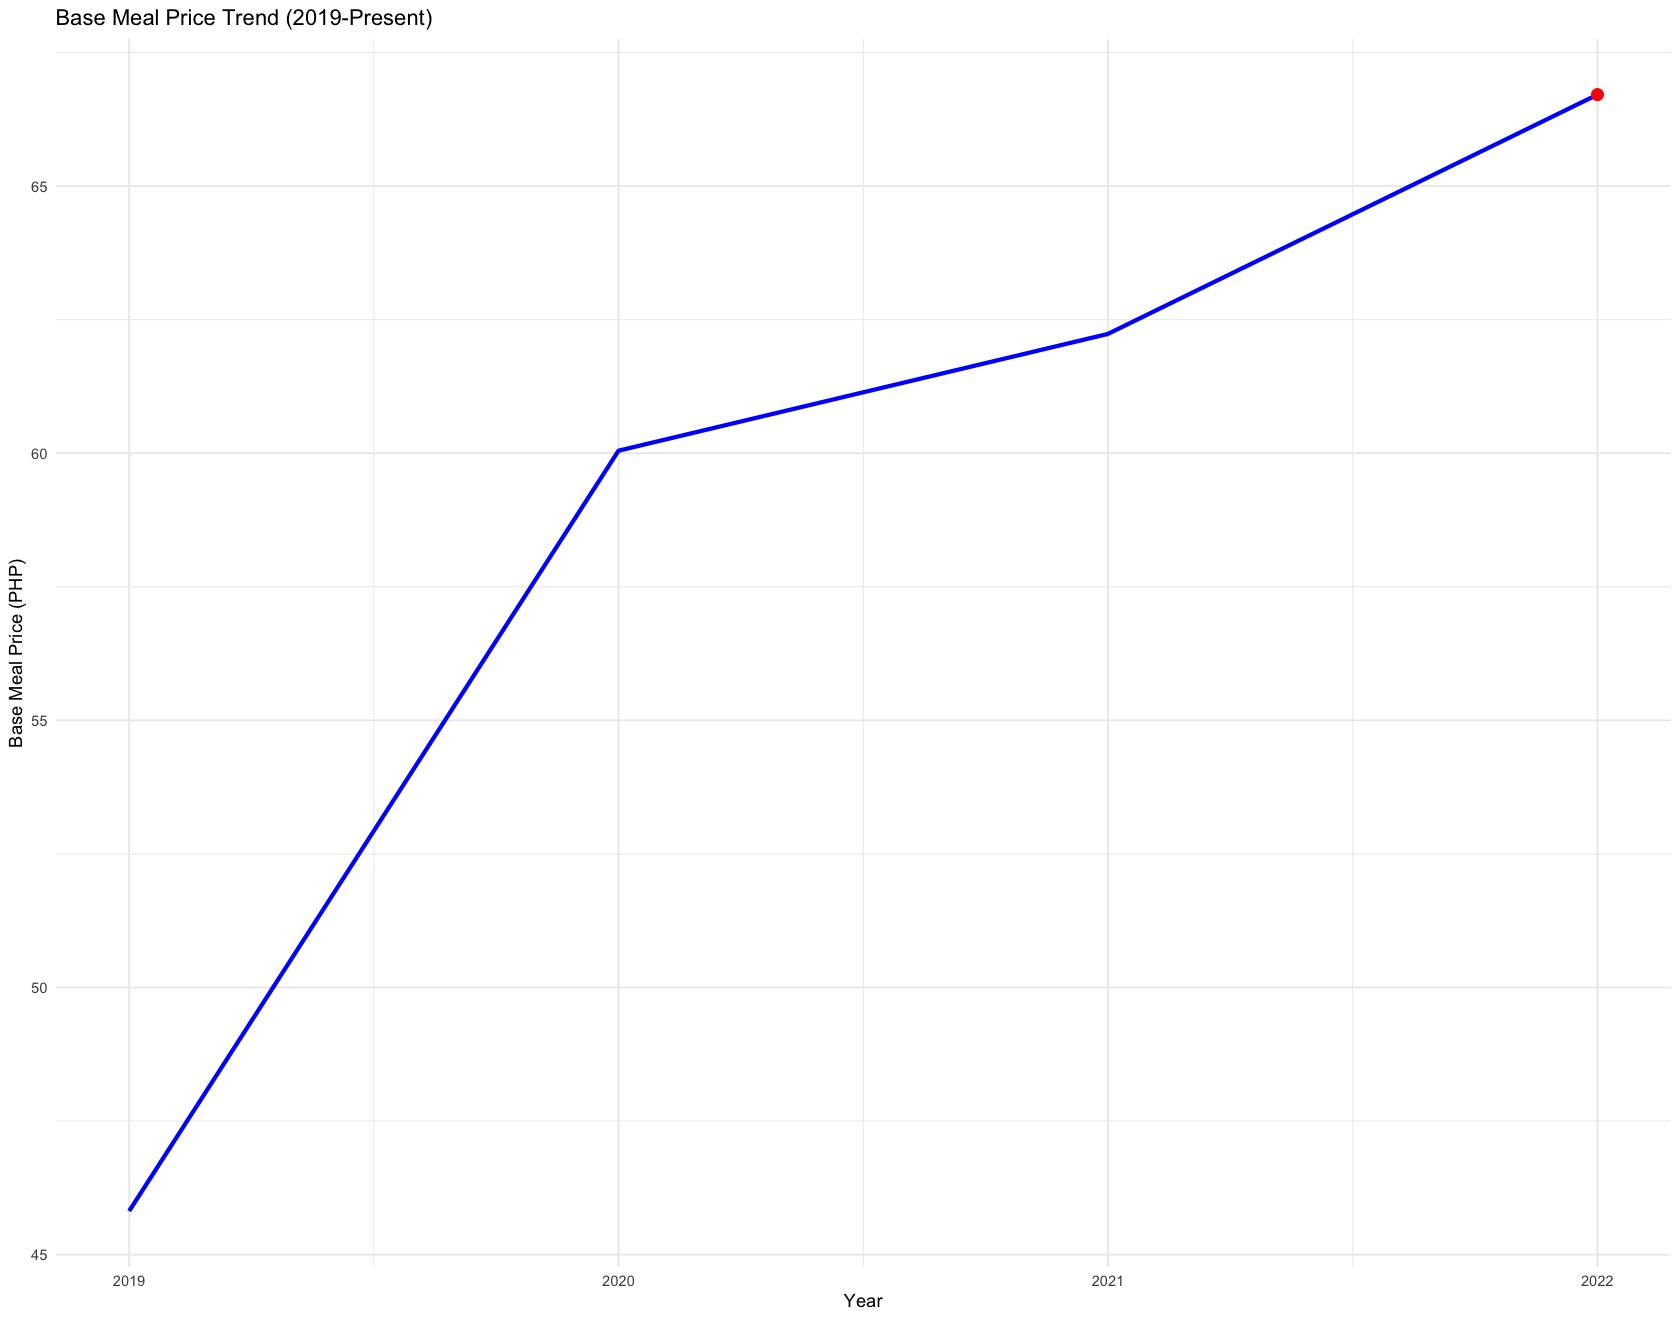

In [12]:
# Line Graph. Base Meal Price Over Time
ggplot(yearly_avg_prices, aes(x = Year, y = Base_Meal_Price)) +
  geom_line(color = "blue", linewidth = 1.2) +
  geom_point(data = yearly_avg_prices[yearly_avg_prices$Year == max(yearly_avg_prices$Year), ], color = "red", size = 3) +
  labs(title = "Base Meal Price Trend (2019-Present)", x = "Year", y = "Base Meal Price (PHP)") +
  theme_minimal()

In [13]:
# Find the latest year
latest_year <- max(yearly_avg_prices$Year)

# Extract the Base_Meal_Price for the latest year
latest_base_price <- yearly_avg_prices %>%
  filter(Year == latest_year) %>%
  pull(Base_Meal_Price)

# Print the recommended base price
print(paste("Recommended Base Meal Price:", latest_base_price, "PHP"))

[1] "Recommended Base Meal Price: 66.711943077597 PHP"


**Line Plot: Base Meal Price Over Time**

To provide a clear and comprehensive understanding of the estimated base meal price over time, we use the calculated Base_Meal_Price metric derived from the weighted average prices of key ingredient categories — Protein, Carbohydrate, Vegetable, Fruit, and Oils and Condiments. The weights are based on a realistic portion size for a typical meal, measured in grams. This calculation enables us to reflect the evolving cost of a balanced meal over the years.

This line plot highlights the trend of the base meal price over the observed years, offering insights into food cost inflation and market dynamics. The upward or downward shifts in the line reflect changing ingredient prices, with potential peaks indicating times of economic strain or supply chain issues. Notably, consistent increases would suggest a steady rise in the cost of living, while fluctuations might point to seasonal or policy-driven impacts on ingredient availability and pricing.


**Table: Average Price of Ingredient Categories and Base Meal Price (2019–2022)**

| Year | Carbohydrate (PHP/kg) | Protein (PHP/kg) | Vegetable (PHP/kg) | Fruit (PHP/kg) | Oils and Condiments (PHP/kg) | Other (PHP/kg) | Base Meal Price (PHP) |
|------|----------------------|------------------|---------------------|----------------|----------------------------|----------------|-----------------------|
| 2019 | 40.4                  | 170.0            | 60.4                 | 0.0            | 0.0                        | 0.0            | 0.0                   |
| 2020 | 47.8                  | 177.0            | 69.3                 | 60.5           | 104.0                      | 56.8           | 60.67                 |
| 2021 | 43.0                  | 187.0            | 81.3                 | 63.7           | 112.0                      | 58.7           | 64.25                 |
| 2022 | 53.1                  | 193.0            | 90.3                 | 63.1           | 117.0                      | 66.4           | 66.71                 |

The table provides a clear view of the average ingredient prices per kilogram and the calculated base meal price from 2019 to 2022. The Base Meal Price is derived from weighted averages of ingredient costs, with the following meal composition:


| Component            | Weight (g) |
|----------------------|------------|
| Protein              | 175        |
| Carbohydrate         | 250        |
| Vegetable            | 100        |
| Fruit                | 150        |
| Oils and Condiments  | 10         |


The Base Meal Price for 2019 is missing (NA) because certain key categories (like Fruits and Oils and Condiments) had prices recorded as 0. This suggests incomplete data collection for that year — possibly due to market unavailability or lack of reported prices. As these categories are essential components of the meal composition, the absence of their prices makes the base meal price calculation incomplete, resulting in an NA value.

The table reveals a consistent increase in ingredient prices over the years, particularly for protein and oils and condiments, contributing significantly to the rising cost of the base meal. The base meal price in 2019 remains at 0 PHP due to the absence of recorded fruit and oils-and-condiments prices for that year, which skews the overall computation.

In subsequent years, the base meal price stabilizes and shows a gradual increase, reaching a **recommended base meal price of PHP 66.71 in 2022**. This value aligns with the most current data and accurately reflects the weighted costs of a balanced meal. This serves as a sound basis for determining employee meal allowances, taking into account market price trends and nutritional composition.


#### Price Scaling

In [14]:
latest_base_price <- latest_base_price

# Scaling Factor to amplify the price as the latest base price only accounts for food cost.
# The scaling factors mimics markup, overhead cost and other cost of production
scaling_factor <- 3.8

# Calculate the scaled base price
scaled_base_price <- latest_base_price * scaling_factor

# Print the scaled base price
print(paste("Scaled Base Meal Price:", scaled_base_price, "PHP"))

# Calculate the daily allowance for one meal by rounding
daily_allowance <- scaled_base_price * 1 # adjust here if needed more than one meal a day
daily_allowance <- round(daily_allowance/10)*10

print(paste("Recommended Daily Meal Allowance:", daily_allowance, "PHP"))

[1] "Scaled Base Meal Price: 253.505383694869 PHP"
[1] "Recommended Daily Meal Allowance: 250 PHP"


**Table: Key Metrics for Meal Allowance Recommendation**

| Metric                                 | Value     |
|---------------------------------------|-----------|
| Latest Year                           | 2022      |
| Base Meal Price (PHP)                 | 66.71     |
| Scaling Factor                        | 3.80      |
| Recommended Daily Meal Allowance (PHP)     | 250.00    |


- Latest Year: Represents the most recent year in the dataset (2022).
- Base Meal Price (PHP): The calculated cost of a balanced meal based on ingredient prices and typical meal composition.
- Scaling Factor: A multiplier used to adjust the base meal price for factors like inflation, market variations, and practical considerations.
- Recommended Daily Allowance (PHP): The proposed daily meal allowance per employee after applying the scaling factor.

#### **Meal Allowance Recommendation and Legal Compliance**

![Three Types of Benefits](https://drive.google.com/uc?id=1vIlGavVWKMae4uOXazW5NG0UYxls2i46)

According to both [Kalibrr (2023)](https://neo-blog.kalibrr.com/blog/de-minimis-per-diem-service-charges-etc-little-known-employee-benefits-in-the-philippines) and [Grant Thornton (2023)](https://www.grantthornton.com.ph/insights/articles-and-updates1/lets-talk-tax/better-perks-for-happier-employees-non-taxability-of-employee-de-minimis-benefits/), meal allowances are generally classified as de minimis benefits in the Philippines, which are non-taxable as long as they do not exceed the prescribed thresholds. While [Kalibrr (2023)](https://neo-blog.kalibrr.com/blog/de-minimis-per-diem-service-charges-etc-little-known-employee-benefits-in-the-philippines) discusses the practice predominantly in the context of the government sector, the principles outlined are equally applicable to private companies aiming to create competitive employee benefits. [Grant Thornton (2023)](https://www.grantthornton.com.ph/insights/articles-and-updates1/lets-talk-tax/better-perks-for-happier-employees-non-taxability-of-employee-de-minimis-benefits/) highlights that meal allowances up to PHP 800 per day are tax-exempt in the government sector, providing a clear benchmark. Our recommended daily meal allowance of PHP 250 is well within this range, ensuring both compliance with Philippine labor regulations and fairness for employees

Given the rising food costs, particularly in basic commodities such as protein, carbohydrates, and vegetables, companies must ensure their meal allowances reflect the current market prices. Our study calculates a Base Meal Price based on real-time food price data and scales it by a factor of 3.8 to cover additional overhead costs and business expenses.

In [15]:
key_data <- data.frame(
  Metric = c("Latest Year", "Base Meal Price (PHP)", "Scaling Factor", "Recommended Daily Allowance (PHP)"),
  Value = c(latest_year, latest_base_price, scaling_factor, daily_allowance)
)

print(key_data)

                             Metric      Value
1                       Latest Year 2022.00000
2             Base Meal Price (PHP)   66.71194
3                    Scaling Factor    3.80000
4 Recommended Daily Allowance (PHP)  250.00000


### Option 2: Inflation-Adjusted Meal Allowance Model

In [16]:
# Actual CPI data from PSA (2018=100)
cpi_data <- data.frame(
  Year = 2018:2022,
  CPI = c(97.2, 101.5, 104.5, 108.4, 113.8)
)

# Calculate inflation rates
cpi_data <- cpi_data %>%
  mutate(
    Previous_CPI = lag(CPI),
    Inflation_Rate = ifelse(is.na(Previous_CPI), 0, (CPI - Previous_CPI) / Previous_CPI)
  )

# Base meal allowance (from Option 1)
base_allowance <- daily_allowance # PHP 250 scaled and rounded base from

# Calculate adjusted allowances
allowance_data <- cpi_data %>%
  mutate(
    Adjusted_Allowance_CPI = base_allowance * (1 + Inflation_Rate),
    COLA_Rate = pmin(Inflation_Rate * 0.8, 0.05),
    Adjusted_Allowance_COLA = base_allowance * (1 + COLA_Rate)
  ) %>%
  select(Year, CPI, Inflation_Rate, COLA_Rate, Adjusted_Allowance_CPI, Adjusted_Allowance_COLA)

print(allowance_data)

  Year   CPI Inflation_Rate  COLA_Rate Adjusted_Allowance_CPI
1 2018  97.2     0.00000000 0.00000000               250.0000
2 2019 101.5     0.04423868 0.03539095               261.0597
3 2020 104.5     0.02955665 0.02364532               257.3892
4 2021 108.4     0.03732057 0.02985646               259.3301
5 2022 113.8     0.04981550 0.03985240               262.4539
  Adjusted_Allowance_COLA
1                250.0000
2                258.8477
3                255.9113
4                257.4641
5                259.9631


**Table: Summary of the Inflationary Adjustments Applied**

The following table summarizes the inflationary adjustments applied to the base meal price using both CPI and COLA methods:

| Year | CPI | Inflation Rate | COLA Rate | Adjusted Allowance (CPI) | Adjusted Allowance (COLA) |
|------|-----|----------------|-----------|--------------------------|---------------------------|
| 2018 | 97.2 | 0.00000000     | 0.00000000 | 250.0000                 | 250.0000                  |
| 2019 | 101.5 | 0.04423868    | 0.03539095 | 261.0597                 | 258.8477                  |
| 2020 | 104.5 | 0.02955665    | 0.02364532 | 257.3892                 | 255.9113                  |
| 2021 | 108.4 | 0.03732057    | 0.02985646 | 259.3301                 | 257.4641                  |
| 2022 | 113.8 | 0.04981550    | 0.03985240 | 262.4539                 | 259.9631                  |

#### Interpretation of Inflationary Treatments

##### 1. CPI-Based Adjustment

- **Method**: The inflation rate is directly derived from the CPI changes, and the base allowance is adjusted by this rate.
- **Impact**: This method fully accounts for inflationary pressures, ensuring that the meal allowance maintains its purchasing power over time.
- **Observations**:
  - In 2019, the CPI increased significantly, leading to a substantial rise in the adjusted allowance (PHP 261.06).
  - In 2020, despite a lower inflation rate, the allowance decreased slightly due to the previous year's adjustment.
  - In 2021 and 2022, the allowance increased again as inflation rates rose.

##### 2. COLA-Based Adjustment

- **Method**: The COLA rate is capped at 80% of the inflation rate or a maximum of 5%, whichever is lower.
- **Impact**: This approach moderates the inflationary adjustment, providing a more controlled increase in allowances.
- **Observations**:
  - In 2019, the COLA-adjusted allowance increased less than the CPI-adjusted allowance (PHP 258.85 vs. PHP 261.06).
  - In subsequent years, the COLA adjustments resulted in smaller increases compared to CPI adjustments, reflecting a more conservative approach to cost-of-living adjustments.
  - The COLA method ensures that allowances rise but at a slower pace, which can be beneficial for budget management.

##### Summary of Key Differences

- **CPI Method**: Fully reflects inflationary changes, ensuring that allowances maintain purchasing power but may result in larger adjustments.
- **COLA Method**: Moderates inflationary impacts, providing more stable and predictable adjustments, which can be advantageous for budget planning.

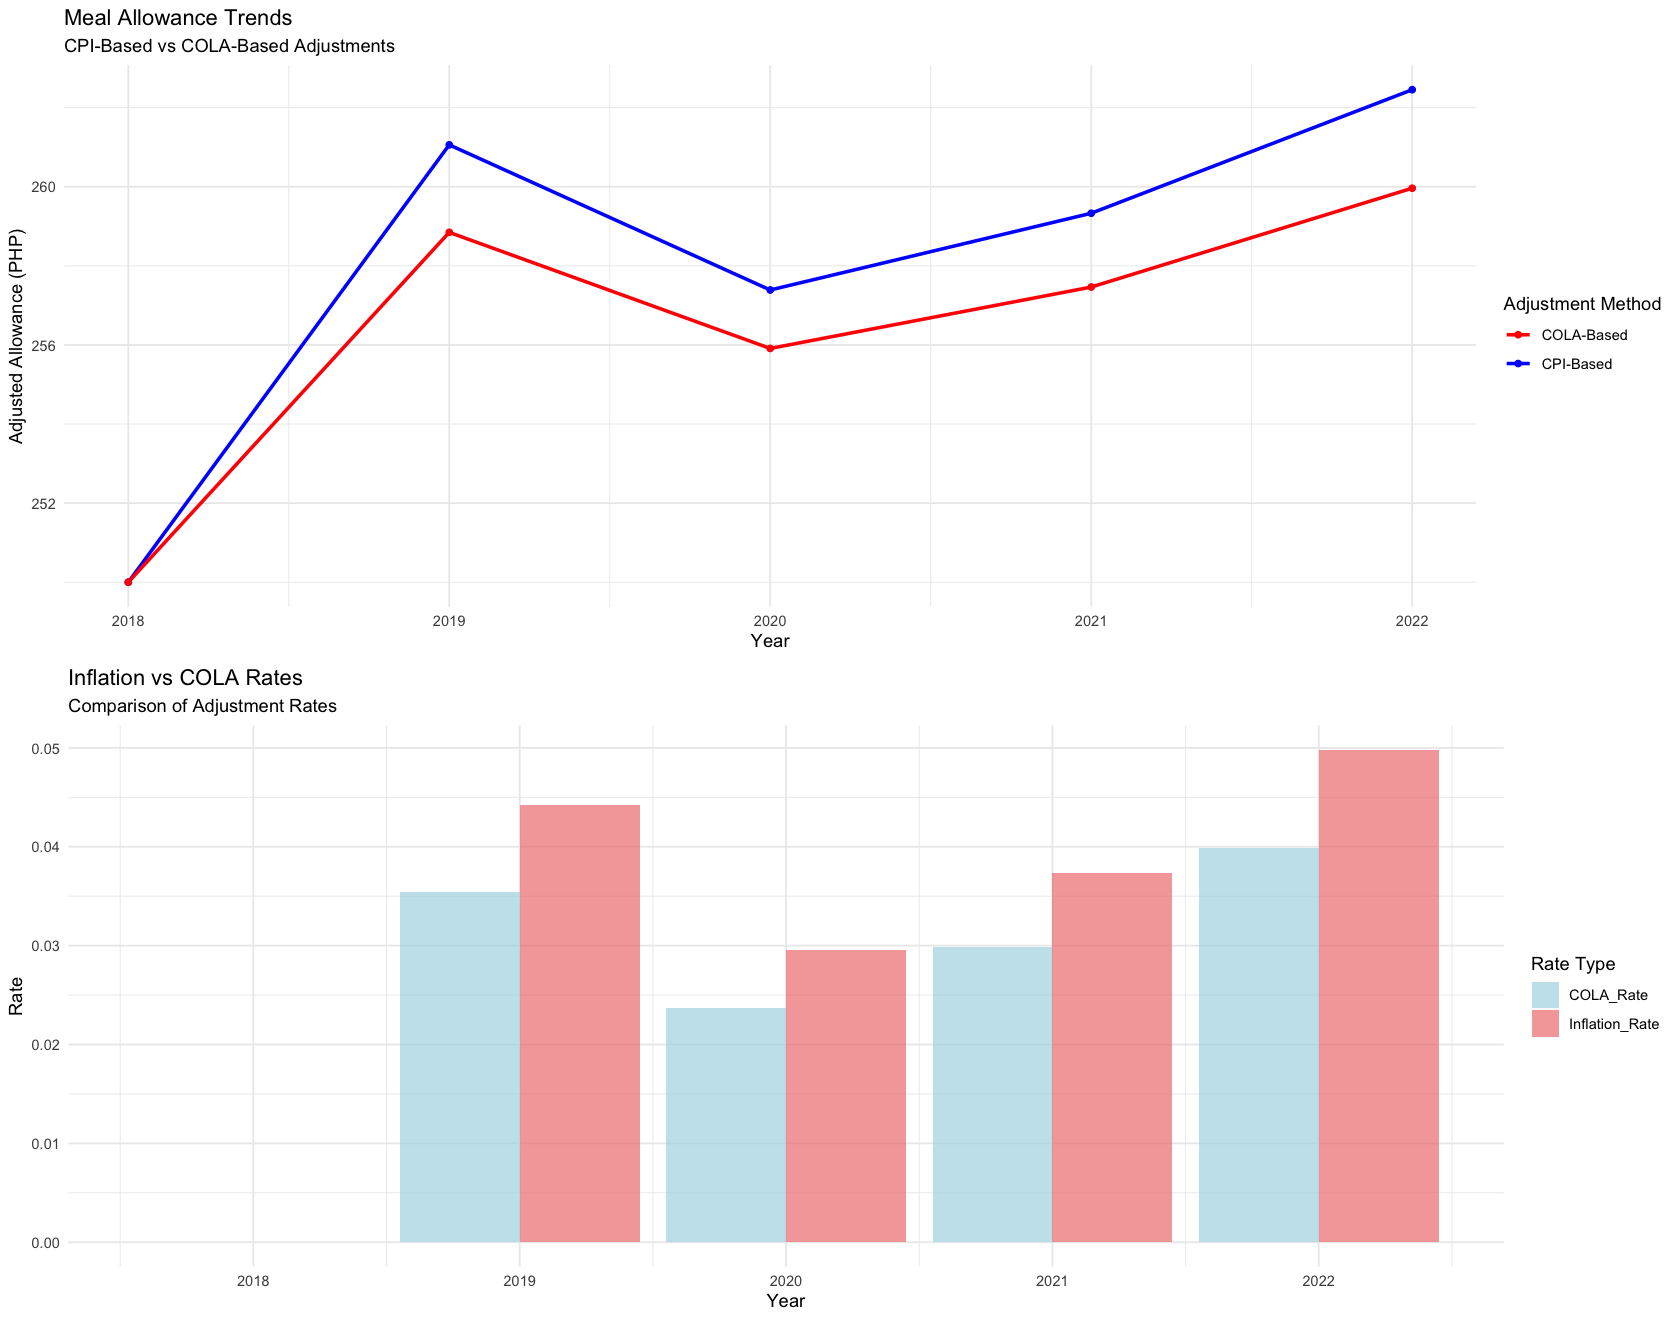

In [17]:
library(ggplot2)
library(tidyr)
library(gridExtra)

# Reshape the data to long format
allowance_data_long <- allowance_data %>%
  pivot_longer(cols = c(Inflation_Rate, COLA_Rate),
               names_to = "Rate_Type",
               values_to = "Rate")

# Create combined visualization with dodged bars
grid.arrange(
  # Top plot: Allowance trends (remains unchanged)
  ggplot(allowance_data, aes(x = Year)) +
    geom_line(aes(y = Adjusted_Allowance_CPI, color = "CPI-Based"), size = 1) +
    geom_line(aes(y = Adjusted_Allowance_COLA, color = "COLA-Based"), size = 1) +
    geom_point(aes(y = Adjusted_Allowance_CPI, color = "CPI-Based")) +
    geom_point(aes(y = Adjusted_Allowance_COLA, color = "COLA-Based")) +
    scale_color_manual(name = "Adjustment Method", 
                      values = c("CPI-Based" = "blue", "COLA-Based" = "red")) +
    theme_minimal() +
    labs(title = "Meal Allowance Trends",
         subtitle = "CPI-Based vs COLA-Based Adjustments",
         x = "Year",
         y = "Adjusted Allowance (PHP)") +
    theme(legend.position = "right"),
  
  # Bottom plot: Rate comparison with dodged bars
  ggplot(allowance_data_long, aes(x = Year, y = Rate, fill = Rate_Type)) +
    geom_bar(stat = "identity", position = "dodge", alpha = 0.7) +
    scale_fill_manual(name = "Rate Type",
                      values = c("Inflation_Rate" = "lightCoral", "COLA_Rate" = "lightBlue")) +
    theme_minimal() +
    labs(title = "Inflation vs COLA Rates",
         subtitle = "Comparison of Adjustment Rates",
         x = "Year",
         y = "Rate") +
    theme(legend.position = "right"),
  
  ncol = 1, nrow = 2,
  heights = c(1, 1)
)


**Temporal Line Plot (Top Panel): Allowance Trends**

**CPI-Based Allowance (Blue Line)**  - Shows the full impact of inflation on meal allowances
  - Represents the theoretical purchasing power adjustment
  - Follows the exact inflation rate changes


**COLA-Based Allowance (Red Line)**  - Demonstrates the moderated adjustment approach
  - Limited to 80% of inflation rate
  - Capped at maximum 5% annual increase
  
**Allowance Gap**  - The growing gap between CPI and COLA lines indicates cumulative differences in purchasing power
  - COLA-based allowances maintain lower growth rates
  - This gap represents the trade-off between cost control and full inflation protection

**Dodged Bar Chart (Bottom Panel): Rate Comparison**

**Inflation Rate (Light Blue Bars)**  - Shows actual inflation rate for each year
  - Represents the pure price increase in the economy
  - Provides context for allowance adjustments


**COLA Rate (Light Coral Bars)**  - Displays the applied adjustment rate
  - Shows the moderated impact on allowances
  - Illustrates the protective cap at 5%
**Rate Relationship**  - COLA rates consistently track below inflation rates
  - The 80% limitation and 5% cap create a buffer against extreme inflation
  - This moderation helps maintain budget predictability

**Trend Analysis**  - Both lines show upward trends, indicating consistent inflation pressure
  - The COLA-based approach provides more stable, predictable growth
  - The visualization helps identify periods of higher inflation pressure


### Option 3: Predictive Model

The predictive model for staff meal allowance uses linear regression to forecast future meal prices based on historical trends. This approach provides a data-driven method for planning meal allowances while accounting for inflationary pressures.

In [18]:
# Create the linear regression model
model <- lm(Base_Meal_Price ~ Year, data = yearly_avg_prices)

# Get the model summary (optional, for diagnostics)
summary(model)


Call:
lm(formula = Base_Meal_Price ~ Year, data = yearly_avg_prices)

Residuals:
      1       2       3       4 
-3.1552  4.5889  0.2879 -1.7215 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept) -13049.167   3728.902  -3.499   0.0728 .
Year             6.487      1.846   3.515   0.0723 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.127 on 2 degrees of freedom
Multiple R-squared:  0.8607,	Adjusted R-squared:  0.791 
F-statistic: 12.36 on 1 and 2 DF,  p-value: 0.07227


**Table: Regression Results Summary**

| **Component**                    | **Value**      | **Interpretation**                                                                                                                                  |
|-----------------------------------|----------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| **Model**                         | `lm(Base_Meal_Price ~ Year)` | This is the linear model being fitted, where `Base_Meal_Price` is predicted based on the `Year`.                                           |
| **Residuals**                     | -3.1552, 4.5889, 0.2879, -1.7215 | These are the residuals from the model, showing the differences between the observed and predicted values. A smaller residual indicates a better fit. |
| **(Intercept) Estimate**          | -13049.167     | This is the intercept of the model, representing the estimated `Base_Meal_Price` when `Year` is 0. However, this value is not practically meaningful in this case as `Year = 0` is outside the data range. |
| **(Intercept) Std. Error**        | 3728.902       | This is the standard error of the intercept estimate. A smaller value indicates more precision in estimating the intercept.                      |
| **(Intercept) t-value**           | -3.499         | This is the t-statistic for the intercept. It measures how many standard errors the intercept is away from 0. A value closer to 0 suggests that the intercept is not significantly different from 0. |
| **(Intercept) p-value**           | 0.0728         | This p-value indicates the probability that the intercept is significantly different from 0. A value less than 0.05 would indicate significance, but here the result is marginal. |
| **Year Estimate**                 | 6.487          | This is the slope of the regression line, meaning that for each additional year, the `Base_Meal_Price` increases by approximately 6.487 units (PHP). |
| **Year Std. Error**               | 1.846          | This is the standard error for the `Year` coefficient. It measures the uncertainty around the estimated slope. A smaller value suggests more precision. |
| **Year t-value**                  | 3.515          | This is the t-statistic for the `Year` coefficient. It indicates how many standard errors the slope is away from 0. A higher t-value suggests the slope is significantly different from 0. |
| **Year p-value**                  | 0.0723         | The p-value for the `Year` coefficient tests whether the `Year` variable has a statistically significant effect on `Base_Meal_Price`. Here, the p-value is close to 0.05, indicating a marginal effect. |
| **Residual Standard Error**       | 4.127          | This is the standard deviation of the residuals. It tells us how much the observed values deviate from the predicted values on average. A smaller value indicates a better fit of the model. |
| **Degrees of Freedom**            | 2              | This is the number of independent pieces of information used to estimate the parameters of the model. The degrees of freedom here are low due to a small sample size. |
| **Multiple R-squared**            | 0.8607         | This indicates that approximately 86.07% of the variability in `Base_Meal_Price` can be explained by the `Year`. A higher R-squared value suggests a better fit. |
| **Adjusted R-squared**            | 0.791          | This adjusts the R-squared value based on the number of predictors in the model. It is a better measure when comparing models with different numbers of predictors. |
| **F-statistic**                   | 12.36          | This tests the overall significance of the model. A high F-statistic indicates that the model explains a significant amount of variability in the data. |
| **F-statistic Degrees of Freedom**| 1 and 2        | The F-statistic is tested against 1 degree of freedom for the numerator (number of predictors) and 2 degrees of freedom for the denominator (residuals). |
| **F-statistic p-value**           | 0.07227        | This p-value tests whether the overall regression model is statistically significant. A p-value greater than 0.05 indicates that the model as a whole is not significant at the 5% level, although it is marginally significant here. |
| **Significance Codes**            | `0 ‘***’`, `0.001 ‘**’`, `0.01 ‘*’`, `0.05 ‘.’`, `0.1 ‘ ’`, `1` | This provides a quick reference to the significance levels: `***` for very strong significance, `**` for strong, `*` for moderate, `.` for weak, and no symbol for no significance. |

####  Key Findings

- Base meal prices increase by PHP 6.49 per year
- The model explains 86.07% of the price variation (R-squared = 0.8607)
- Both the intercept and year coefficient are marginally significant (p ≈ 0.072)

#### Model Components

1. **Coefficients**:
- Intercept (- PHP 13,049): Represents the theoretical base meal price in year 0
- Year Effect (+ PHP 6.49): Each additional year increases the base meal price by PHP 6.49


2. **Statistical Measures**:
- Residual Standard Error: 4.13 units (measure of prediction accuracy)
- Adjusted R-squared: 0.791 (accounts for model complexity)
- F-statistic: 12.36 (tests overall model significance)

#### Interpretation

- **Intercept**: The intercept suggests that when `Year = 0`, the `Base_Meal_Price` is -13049.167 PHP, though this value is not meaningful because `Year = 0` is outside the data range.
- **Year**: The coefficient for `Year` is 6.487, meaning that for each year increase, the `Base_Meal_Price` is expected to rise by 6.487 PHP. However, the p-value for `Year` (0.0723) is just above the common significance threshold of 0.05, suggesting that the effect of `Year` is marginally significant.
- **R-squared**: The R-squared value of 0.8607 indicates that the model explains 86.07% of the variability in `Base_Meal_Price`, suggesting a good fit of the model.
- **Residual Standard Error**: The residual standard error of 4.127 indicates that on average, the predictions from the model are off by approximately 4.127 PHP.

#### Limitations

- Small sample size (only 4 observations)
- Marginal statistical significance (p > 0.05)
- Limited ability to detect non-linear trends

Given the small sample size and marginal significance levels, these findings should be interpreted cautiously. In conclusion, the regression model suggests that `Year` has a positive effect on the `Base_Meal_Price`, although this relationship is marginally significant. The model explains a substantial portion of the variance in `Base_Meal_Price` (86.07%), and the residuals indicate a relatively good fit. While the model suggests a clear upward trend in base meal prices over time, collecting additional years of data would help strengthen these conclusions.


In [19]:
# Create a data frame for future years (e.g., 2023 and 2024)
future_years <- data.frame(Year = (max(yearly_avg_prices$Year) + 1):(max(yearly_avg_prices$Year) + 2))

# Predict future meal prices
forecast <- predict(model, newdata = future_years)

# Combine future years and forecasted prices
forecast_data <- data.frame(Year = future_years$Year, Forecasted_Price = forecast)

# Print the forecast
print(forecast_data)

  Year Forecasted_Price
1 2023         74.92093
2 2024         81.40837


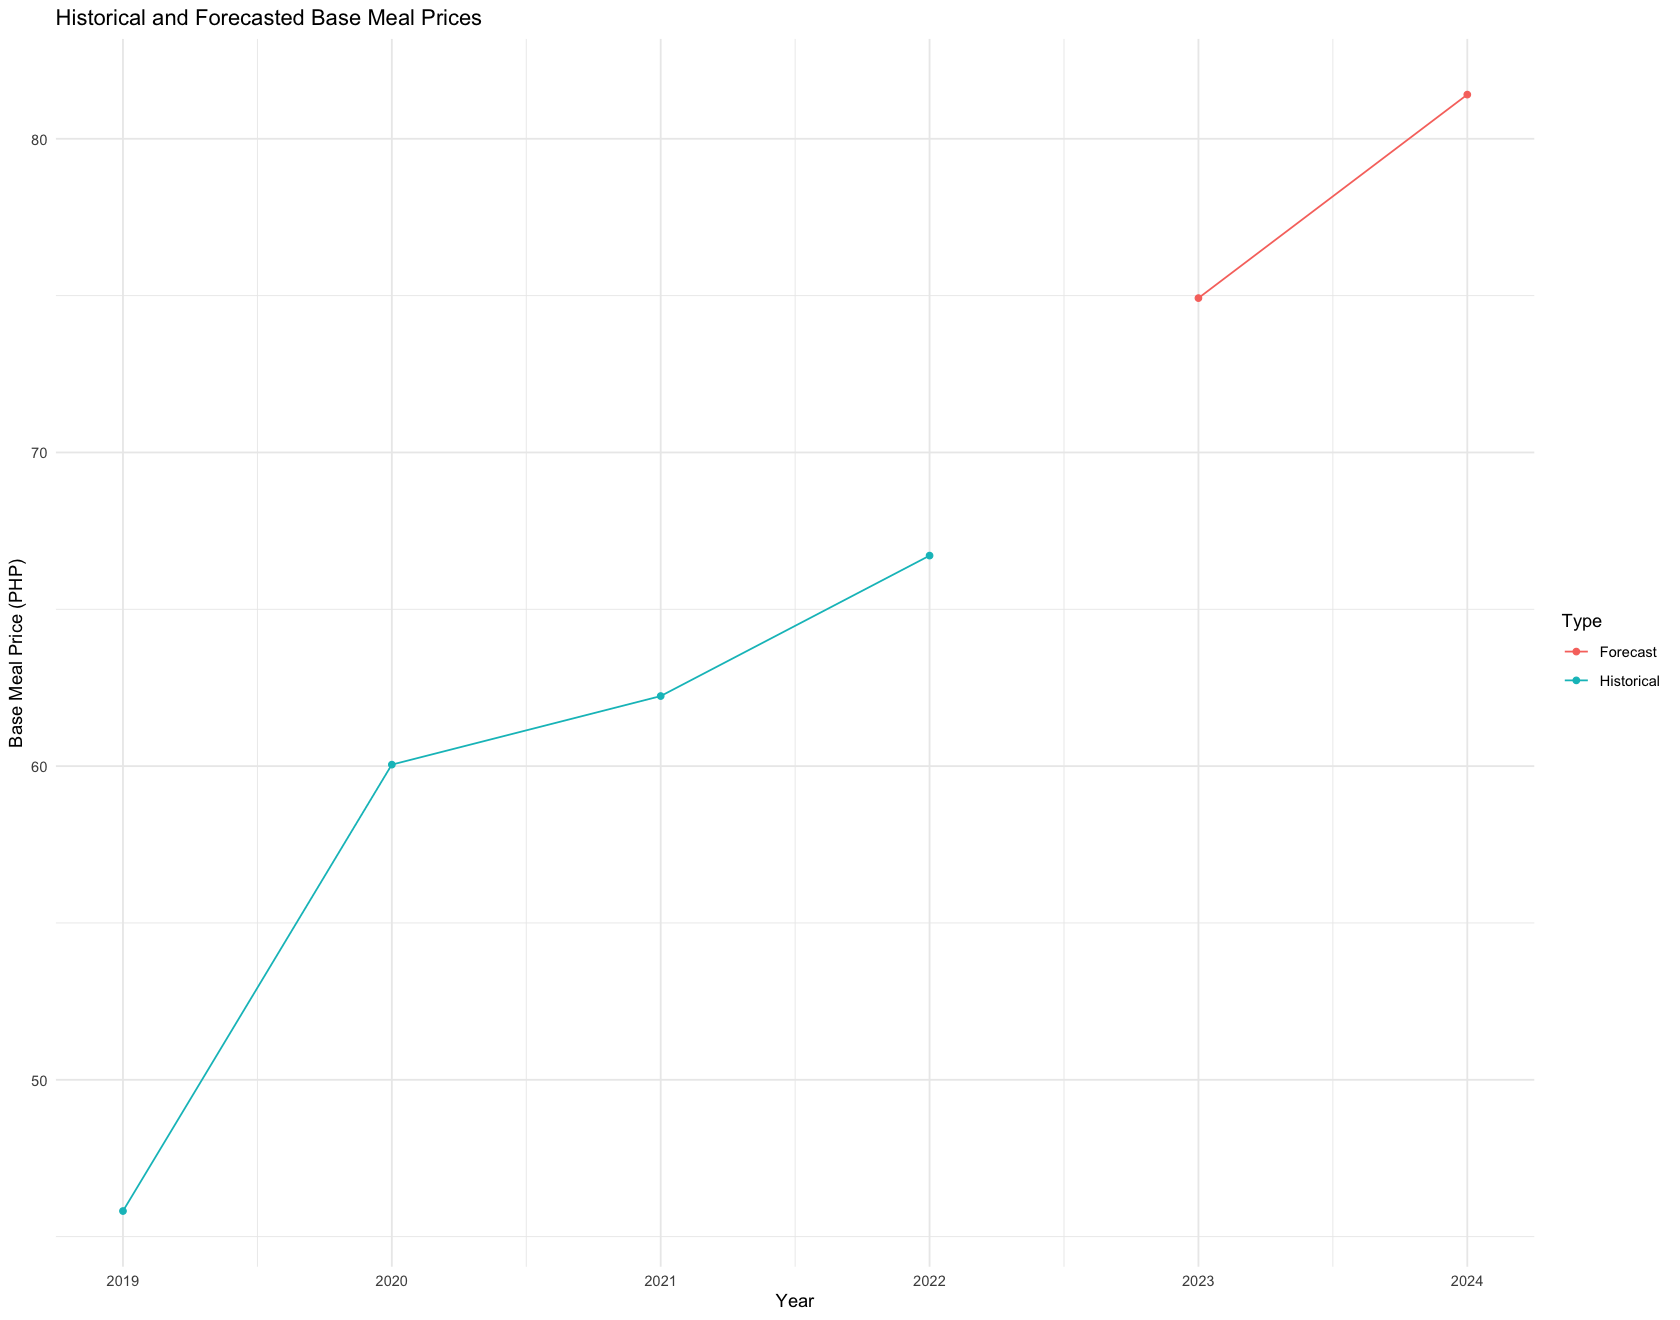

In [20]:
# Combine historical and forecasted data
all_data <- rbind(
  yearly_avg_prices %>% select(Year, Base_Meal_Price) %>% mutate(Type = "Historical"),
  forecast_data %>% rename(Base_Meal_Price = Forecasted_Price) %>% mutate(Type = "Forecast")
)

# Plot the historical and forecasted meal prices
ggplot(all_data, aes(x = Year, y = Base_Meal_Price, color = Type)) +
  geom_line() +
  geom_point() +
  labs(title = "Historical and Forecasted Base Meal Prices", x = "Year", y = "Base Meal Price (PHP)") +
  theme_minimal()

**Line Chart: Historical & Forcasted Recommended Employee's Meal Allowance**

* This chart displays both the historical and forecasted base meal prices over time.
* It allows for visual comparison of the model's fit to the historical data and the forecasted trend.
* The addition of the points on the forecasted data, makes it very clear where the forecast data exists.

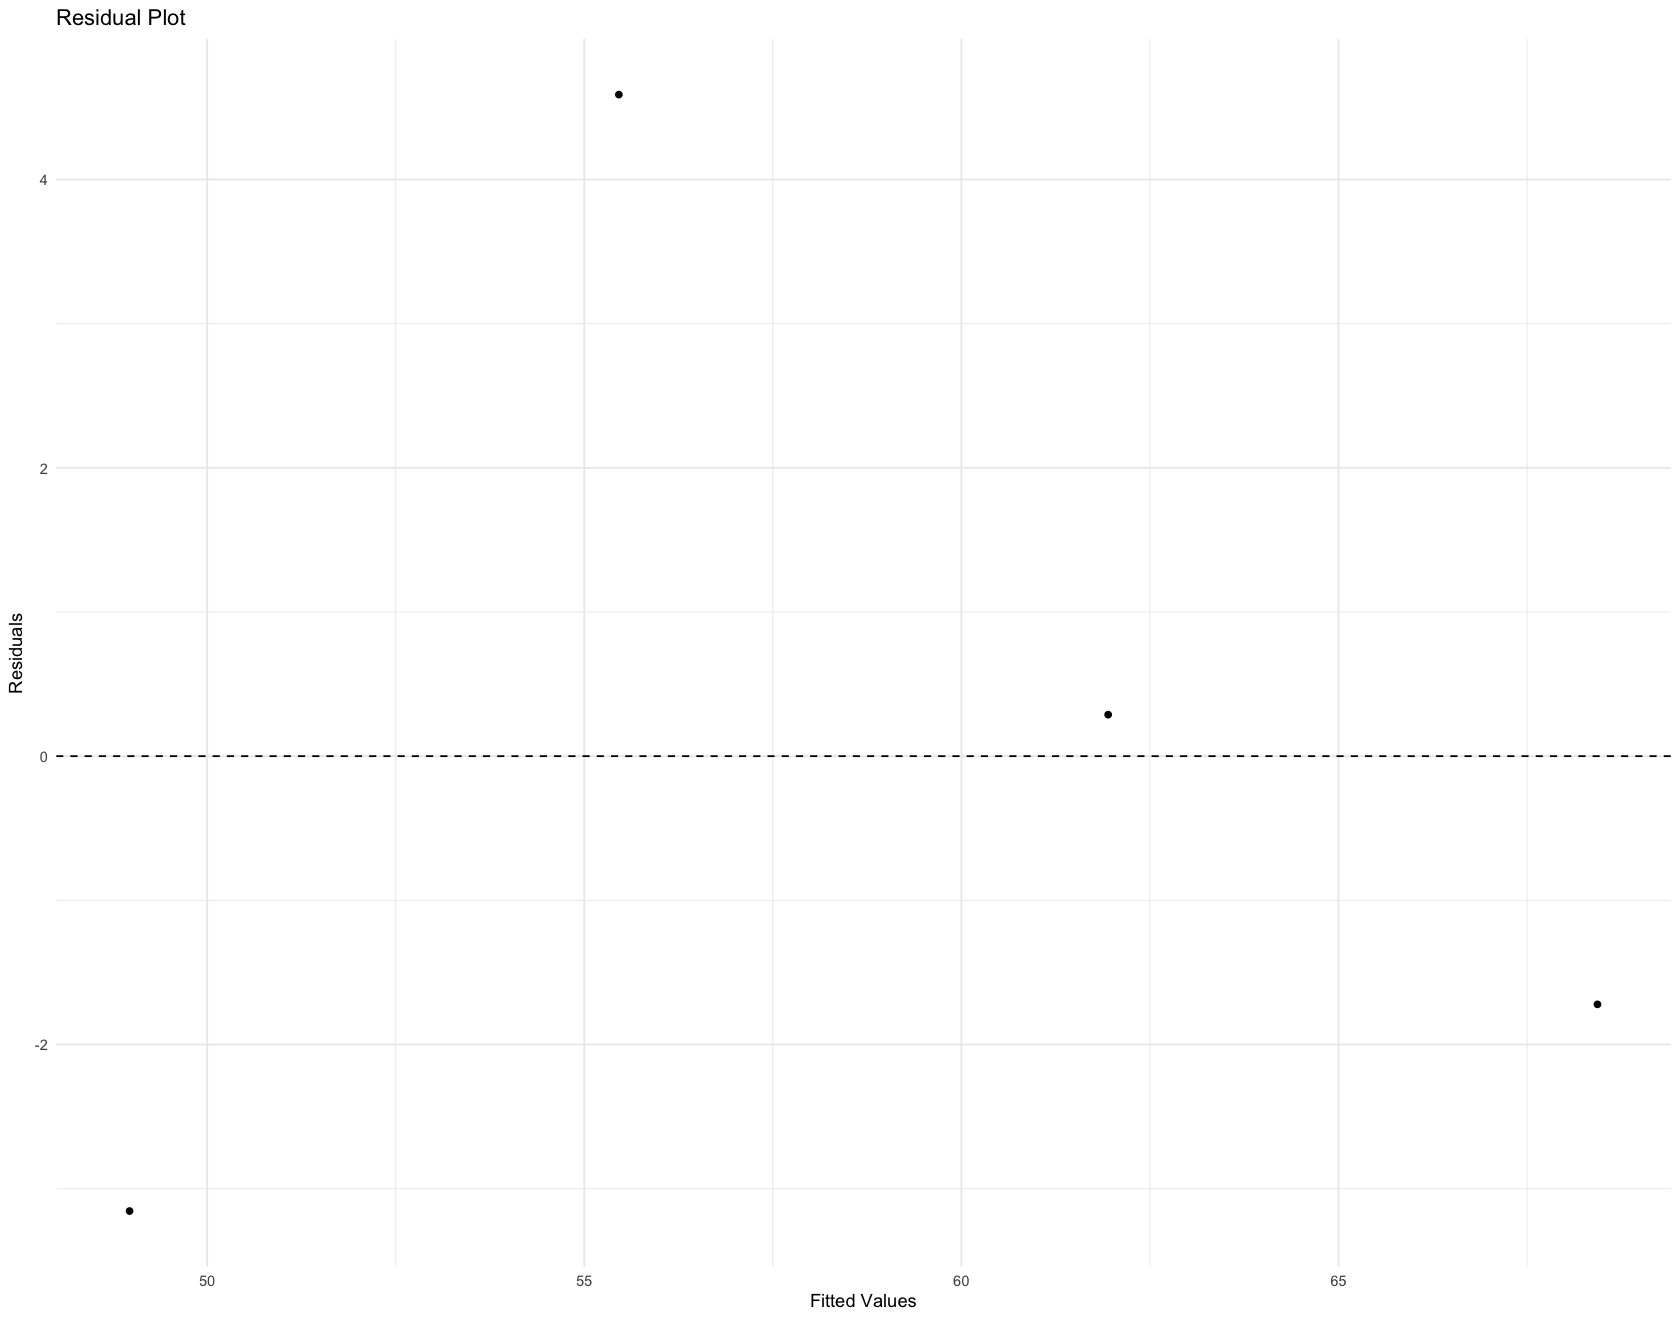

In [21]:
ggplot(model, aes(x = .fitted, y = .resid)) +
  geom_point() +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(title = "Residual Plot",
       x = "Fitted Values",
       y = "Residuals") +
  theme_minimal()

**Residual Plot: For Model Diagnostics**

* This plot shows the residuals (the differences between the observed and predicted values) against the fitted values.
* It's used to assess the model's assumptions, such as linearity and homoscedasticity (constant variance of residuals).
* A random scatter of residuals around zero indicates a good model fit.